# Simple RNN test with iNNvestigate
---
Here I generate a simple numerical problem to analyze with an RNN and try and explain the predictions with iNNvestigate.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras

import innvestigate

Using TensorFlow backend.


### Generate Data

The problem I am going to analyze is just simple parabolas. I generate a dataset of points that form randomized parabolas, remove the last data point of each set, and make it the label so that the network learns to predict the last data point. 


In [2]:
#size of dataset
m = 1000 #number of rows (parabolas)
n = 101 #number of columns (points on the curve)

Create an array that will represent the x values. I do 100 points from -5 to 5.

In [3]:
xmax = 5
xmin = -5

points = np.linspace(xmin,xmax, n)
points = np.array([points,]*m) #creates an array of x values repeated m times

Make an array from the x value where all the values are squared.

Also, make an array of ones. This will be used for the constants.


In [4]:
squared = points**2
constants = np.ones((m,n))

Create 1d column arrays of random coefficients. I do a range of -5 to 5.

In [5]:
a = np.random.rand(m,1)*10 - 5
b = np.random.rand(m,1)*10 - 5
c = np.random.rand(m,1)*10 - 5

Thus, we have what we need for the $a x^2 + b x + c$ format.

Multiply the coefficients with their respective x value matrices.

In [6]:
term1 = a*squared
term2 = b*points
term3 = c*constants

Adding them all together gives our data set.

In [7]:
data = term1 + term2 + term3

Make the last column the labels and remove it from the data.

In [8]:
labels = data[:,-1]
data_wo_last = np.delete(data,-1,1)
data_wo_last = data_wo_last.reshape(1000,100,1)

Split the data into training and testing.

In [9]:
split = int(m * 0.9)

train_data = data_wo_last[:split]
train_labels = labels[:split]

test_data = data_wo_last[split:]
test_labels = labels[split:]

## Create RNN

Next I create the model.

This block of code is from https://www.tensorflow.org/tutorials/sequences/text_generation, and its how the RNN layer is implemented.

Note: LSTM layers seem to work too, but I found no performance differences. Thus, I stuck to this RNN layer because I believe the LSTM layer is typically used where the length of the dataset becomes a problem. 

In [10]:
if tf.test.is_gpu_available():
  rnn = keras.layers.CuDNNGRU
else:
  import functools
  rnn = functools.partial(
    keras.layers.GRU, recurrent_activation='sigmoid')


With a good amount of playing around, this model had fairly accurate predictions with solid explanations. 

In [11]:
model1 = keras.Sequential([
    rnn(128, return_sequences=False, input_shape=[n-1,1]),
    keras.layers.Dense(64),
    keras.layers.Dense(32),
    keras.layers.Dense(1)
])

W0907 19:18:05.031920  7700 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 19:18:05.083298  7700 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0907 19:18:05.088442  7700 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [12]:
optimizer = keras.optimizers.RMSprop(0.001)

model1.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])

W0907 19:18:05.508707  7700 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



### Training and Testing

Train the model on the data

In [13]:
history = model1.fit(
  train_data, train_labels,
  epochs=30)

W0907 19:18:06.333364  7700 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0907 19:18:06.338842  7700 deprecation_wrapper.py:119] From C:\Users\benma\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/30
900/900 [==============================] - 3s 4ms/step - loss: 1594.9681 - mean_absolute_error: 29.9924 - mean_squared_error: 1594.9681
Epoch 2/30
900/900 [==============================] - 3s 3ms/step - loss: 66.1940 - mean_absolute_error: 5.4176 - mean_squared_error: 66.1940TA: 1s - loss: 101.5767 - mean_absolute_error: 6.750
Epoch 3/30
900/900 [==============================] - 2s 3ms/step - loss: 26.8047 - mean_absolute_error: 3.8663 - mean_squared_error: 26.8047
Epoch 4/30
900/900 [==============================] - 2s 3ms/step - loss: 19.0840 - mean_absolute_error: 2.8758 - mean_squared_error: 19.0840
Epoch 5/30
900/900 [==============================] - 2s 2ms/step - loss: 22.5953 - mean_absolute_error: 3.8663 - mean_squared_error: 22.5953
Epoch 6/30
900/900 [==============================] - 3s 3ms/step - loss: 18.5991 - mean_absolute_error: 3.3834 - mean_squared_error: 18.5991
Epoch 7/30
900/900 [==============================] - 3s 3ms/step - loss: 14.5440 - mean_ab

Then to get a good measure of the performance, I plot the predictions vs their actual values.

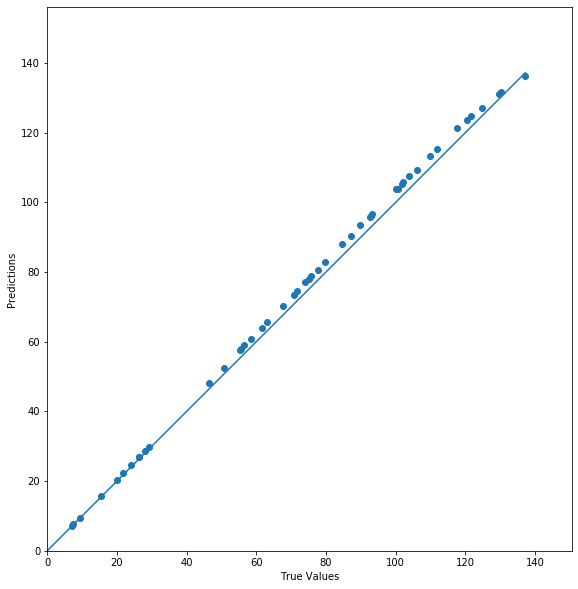

In [14]:
test_predictions = model1.predict(test_data).flatten()

x = np.linspace(0,np.amax(test_labels),1000)

plt.figure(figsize = (10,10))
plt.scatter(test_labels, test_predictions)
plt.plot(x,x)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.show()

### Explanation 

We create our analyzer using LRP and analyze the test data. 

In [15]:
analyzer1 = innvestigate.create_analyzer("lrp.z", model1)
analysis1 = analyzer1.analyze(test_data)

C:\Users\benma\Anaconda3\lib\site-packages\innvestigate\analyzer\base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.recurrent.GRU object at 0x000001BAED552C50>]
  warnings.warn(tmp_message)


This next function is from the iNNVestigate sentiment analysis example (https://github.com/albermax/innvestigate/blob/master/examples/notebooks/sentiment_analysis.ipynb)

It takes in values and the relevance scores, and creates a visual to understand the network's reasoning. 

In [16]:
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores = 0.5 * scores / np.max(np.abs(scores)) + 0.5
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

Now, we analyze some examples. I will print out some key values and plot the parabola along with the analysis. 

Actual Value: 124.71621606819323
Prediction: 127.0951
y-intercept: [-3.83876309]


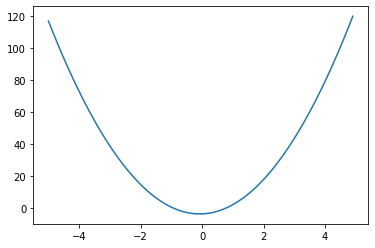

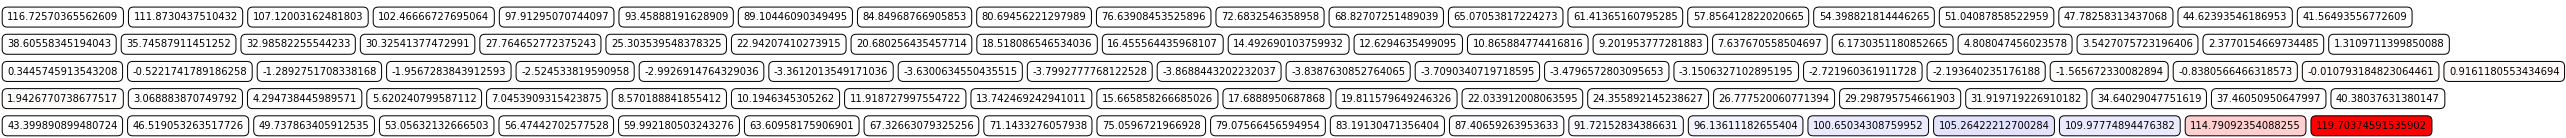

In [17]:
i = 0

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis1[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

Actual Value: -89.67748422751072
Prediction: -88.9849
y-intercept: [0.02679757]


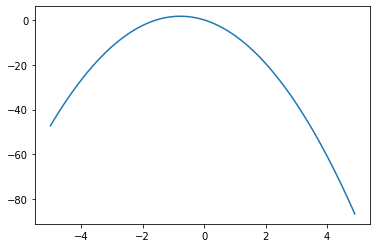

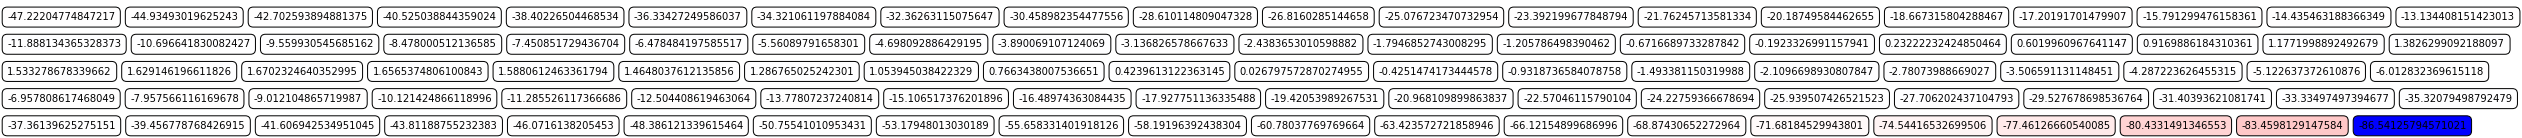

In [19]:
i = 2

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis1[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

Actual Value: -8.647151289848962
Prediction: -10.861169
y-intercept: [-2.49122057]


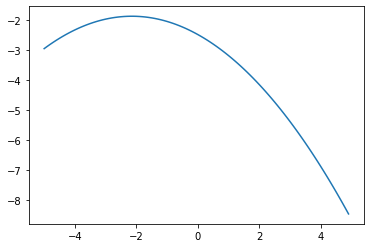

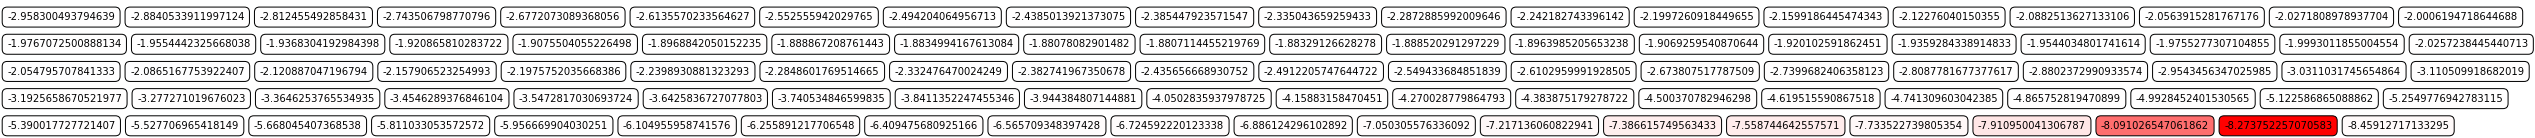

In [30]:
i = 4

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis1[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

Actual Value: -35.689273159180864
Prediction: -38.90311
y-intercept: [1.13121]


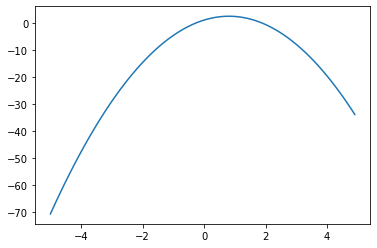

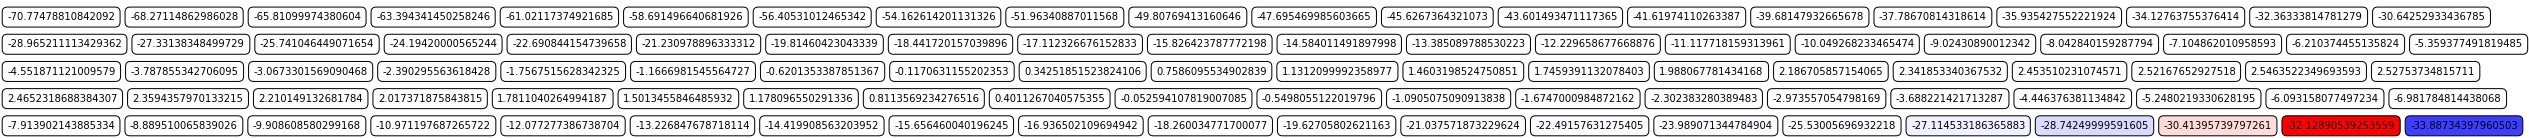

In [31]:
i = 5

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis1[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

As expected, the model is identifying the last few points as most significant.

## Two-layered RNN

Now, I include a model with two RNN layers because it produces some interesting results.

### Build Model

Repeat the same process but now with a second RNN layer.

In [21]:
model2 = keras.Sequential([
    rnn(128, return_sequences=True, input_shape=[n-1,1]),
    rnn(128, return_sequences= False),
    keras.layers.Dense(64),
    keras.layers.Dense(32),
    keras.layers.Dense(1)
])

In [22]:
model2.compile(loss='mean_squared_error',
              optimizer=optimizer,
              metrics=['mean_absolute_error', 'mean_squared_error'])

### Train and Test Model

In [23]:
history = model2.fit(
  train_data, train_labels,
  epochs=30)

Epoch 1/30
900/900 [==============================] - 6s 6ms/step - loss: 1294.0317 - mean_absolute_error: 25.8937 - mean_squared_error: 1294.0317
Epoch 2/30
900/900 [==============================] - 4s 5ms/step - loss: 109.2161 - mean_absolute_error: 7.7147 - mean_squared_error: 109.2161
Epoch 3/30
900/900 [==============================] - 4s 5ms/step - loss: 85.3475 - mean_absolute_error: 7.6501 - mean_squared_error: 85.3475
Epoch 4/30
900/900 [==============================] - 4s 4ms/step - loss: 56.0883 - mean_absolute_error: 5.7864 - mean_squared_error: 56.0883
Epoch 5/30
900/900 [==============================] - 4s 5ms/step - loss: 54.6969 - mean_absolute_error: 6.1513 - mean_squared_error: 54.6969
Epoch 6/30
900/900 [==============================] - 4s 4ms/step - loss: 53.1004 - mean_absolute_error: 5.8716 - mean_squared_error: 53.1004
Epoch 7/30
900/900 [==============================] - 4s 4ms/step - loss: 45.0660 - mean_absolute_error: 5.0128 - mean_squared_error: 45.0660

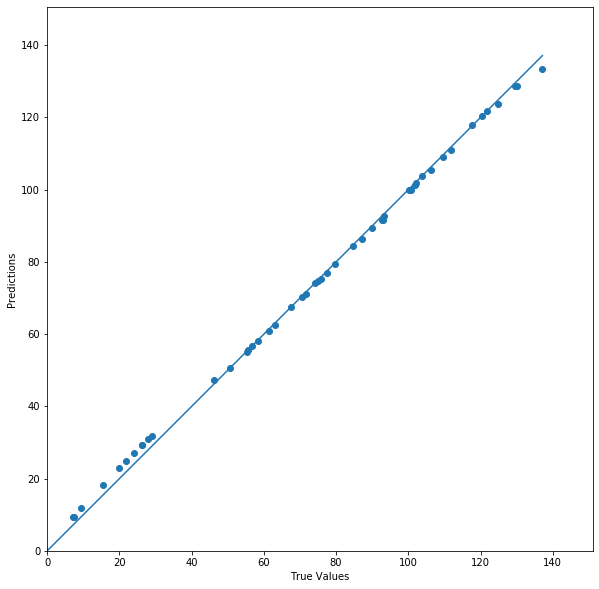

In [24]:
test_predictions = model2.predict(test_data).flatten()

x = np.linspace(0,np.amax(test_labels),1000)

plt.figure(figsize = (10,10))
plt.scatter(test_labels, test_predictions)
plt.plot(x,x)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
plt.show()

### Explain

In [25]:
analyzer2 = innvestigate.create_analyzer("lrp.z", model2)
analysis2 = analyzer2.analyze(test_data)

C:\Users\benma\Anaconda3\lib\site-packages\innvestigate\analyzer\base.py:110: UserWarning: LRP is only tested for convolutional neural networks.
Check triggerd by layers: [<keras.layers.recurrent.GRU object at 0x000001BAF23D6080>, <keras.layers.recurrent.GRU object at 0x000001BAF23B6400>]
  warnings.warn(tmp_message)


Actual Value: 124.71621606819323
Prediction: 123.70691
y-intercept: [-3.83876309]


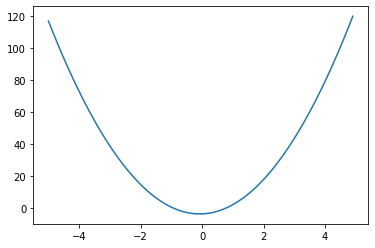

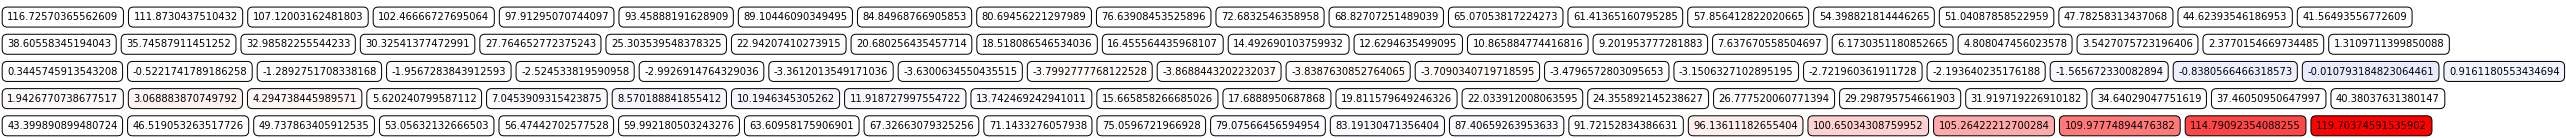

In [26]:
i = 0

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis2[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))


Actual Value: -89.67748422751072
Prediction: -96.33275
y-intercept: [0.02679757]


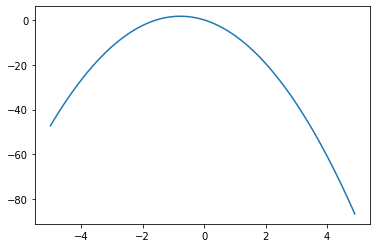

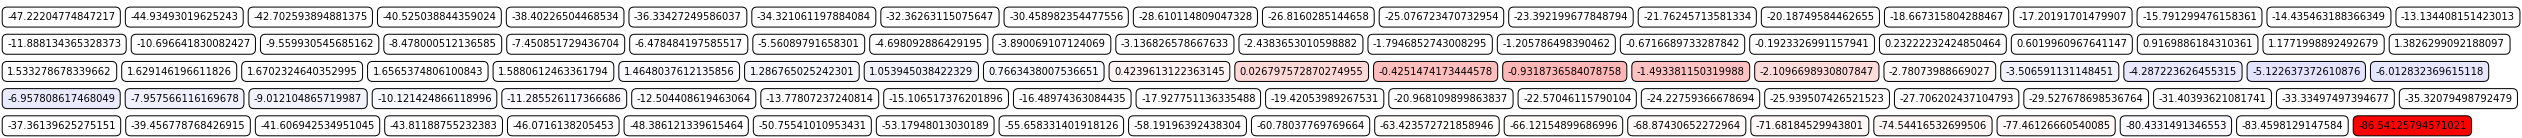

In [28]:
i = 2

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis2[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

Actual Value: -8.647151289848962
Prediction: -10.861169
y-intercept: [-2.49122057]


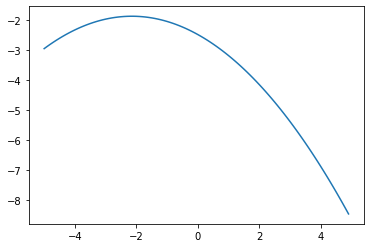

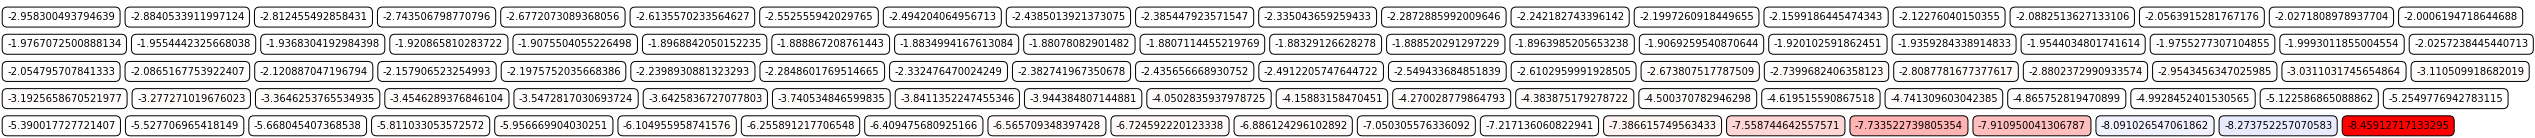

In [33]:
i = 4

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis2[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

Actual Value: -35.689273159180864
Prediction: -38.90311
y-intercept: [1.13121]


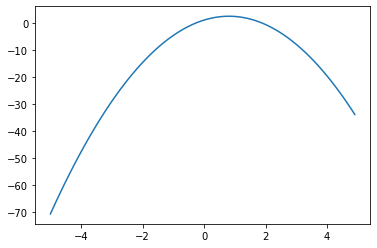

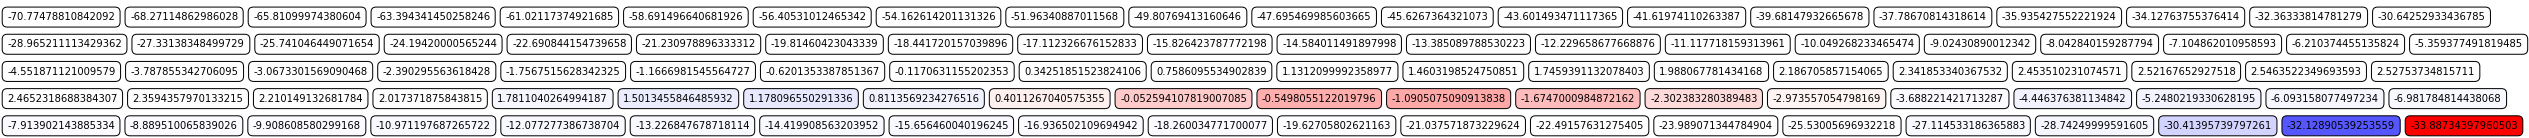

In [34]:
i = 5

plt.plot(points[0][:-1], test_data[i].flatten())

plot_text_heatmap(test_data[i].flatten(), analysis2[i].flatten())

print("Actual Value: " + str(test_labels[i]))
print("Prediction: " + str(test_predictions[i]))
print("y-intercept: " +str(test_data[i,50]))

Now instead of purely putting emphasis on the last points, the model is also putting emphasis on the y-intercept and critical point on the curve, which shows a higher level of thinking as expected. 

## Conclusion

The RNN model was able to identify the simple problem and make fairly accurate predictions. 

Most importantly, iNNvestigate returned sensible explanations for the model's predictions. Thus, this is a positive indication that iNNvestigate can properly explain RNN's.